In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import chromadb
import pandas as pd
from chromadb.config import Settings
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
csv_file_path = 'data/synthetic_clusters_colored.csv'
data = pd.read_csv(csv_file_path)

In [4]:
query_color = "purple"
query_point = data[data['cluster'] == query_color][['x', 'y']].iloc[0]

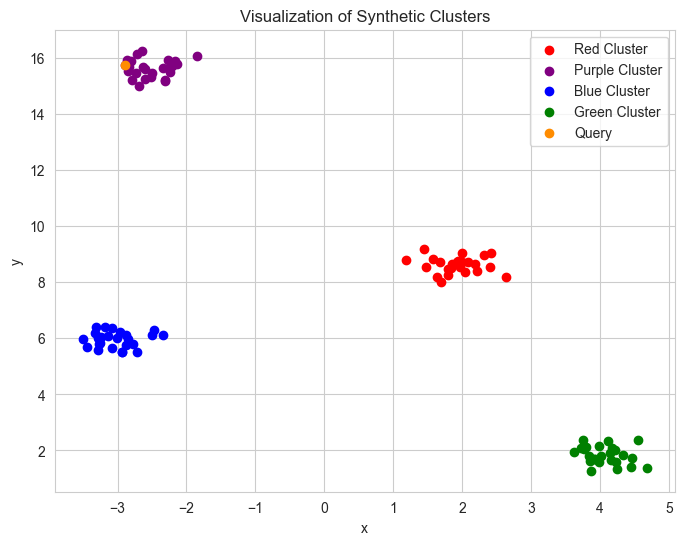

In [5]:
plt.figure(figsize=(8, 6))
for color in data['cluster'].unique().tolist():
    # Select data points belonging to each cluster/color
    cluster_data = data[data['cluster'] == color]
    plt.scatter(cluster_data['x'], cluster_data['y'], color=color, label=f'{color.capitalize()} Cluster')

# Highlight the query point
plt.scatter(query_point['x'], query_point['y'], color='darkorange', edgecolor='darkorange', label='Query', zorder=5)

plt.title('Visualization of Synthetic Clusters')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [6]:
client = chromadb.Client()

collections = client.list_collections()
if collections:
    client.delete_collection(collections[0].name)

In [7]:
index_configuraiton = {
    "lmi:epochs": "[1000]",
    "lmi:model_types": "['MLP']",
    "lmi:lrs": "[0.01]",
    "lmi:n_categories": "[4]"
}

collection_name = "synthetic_collection"
collection = client.create_collection(
    name=collection_name,
    metadata=index_configuraiton
)

In [8]:
# Assuming 'embeddings' are the first three columns
# 'status' is the fourth column, 'document' is the fifth column, and 'id' is the sixth column
collection.add(
    embeddings=data[['x', 'y']].values.tolist(),
    metadatas=[{"cluster": cluster} for cluster in data['cluster']],
    ids=data['id'].values.tolist(),
)

bucket_assignment = collection.build_index()


            LMI Build Config:
            {
                clustering_algorithms: [<function cluster at 0x000001D226C9A1F0>],
                epochs: [1000],
                model_types: ['MLP'],
                learning_rate: [0.01],
                n_categories: [4],
            }
             
LMI built with n_buckets_in_index: 4
Time taken to build: 2.0514938831329346; Time taken to cluster: 0.008370399475097656


### Visualize buckets

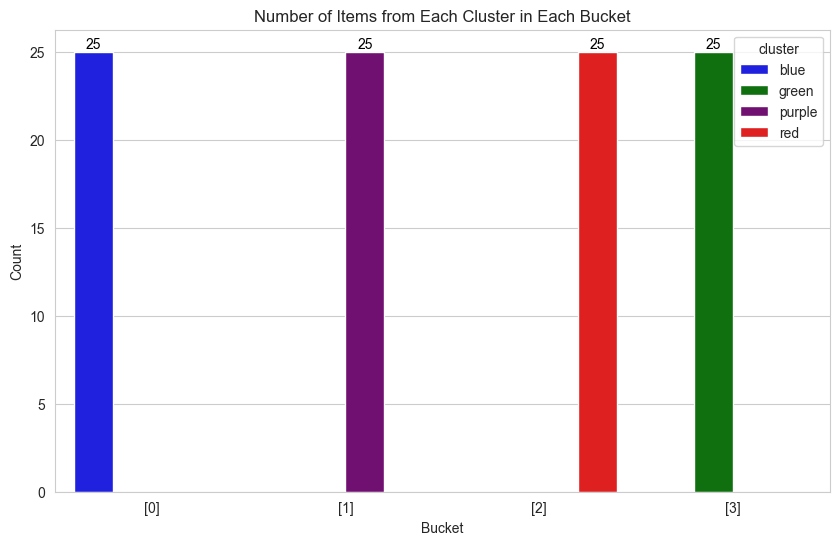

In [9]:
# Map the ids in data to buckets using bucket_labels_new_format
data['bucket'] = data['id'].map(lambda x: list(bucket_assignment.get(x, [])))

# Aggregate data: Count the number of points from each cluster in each mapped bucket
# First, we need to convert the list buckets to a string to be able to group them
data['bucket_str'] = data['bucket'].apply(lambda x: str(x))
bucket_cluster_counts = data.groupby(['bucket_str', 'cluster']).size().unstack(fill_value=0)

# Prepare the data for plotting
plot_data = bucket_cluster_counts.reset_index().melt(id_vars='bucket_str', var_name='cluster', value_name='count')

# Create a palette that uses cluster names as colors
palette = {cluster: cluster for cluster in data['cluster'].unique()}

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_data, x='bucket_str', y='count', hue='cluster', palette=palette)
plt.title('Number of Items from Each Cluster in Each Bucket')
plt.xlabel('Bucket')
plt.ylabel('Count')

# Annotate each bar with the count of elements
for p in ax.patches:
    bar_height = int(p.get_height())
    if bar_height > 0:  # Only annotate bars with a height greater than zero
        ax.annotate(f'{bar_height}', (p.get_x() + p.get_width() / 2., bar_height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()

In [10]:
filter_color = "green"
results = collection.query(
    query_embeddings=list(query_point),
    include=["metadatas", 'embeddings', 'distances'],
    where={"cluster": filter_color},
    n_results=10,
    n_buckets=4,
    use_threshold=False, # TODO: this causes problems, hotfix applied for now
    constraint_weight=0.0,
)

[2023-12-18 21:57:47,448][INFO ][chromadb.lmi.lmi.LMI] Precompute bucket order time: 0.001508951187133789
100%|██████████| 4/4 [00:00<00:00, 1253.15it/s]


In [11]:
print(results['ids'])
print(results['distances'])
print(results['metadatas'])
print(results['bucket_order'])

[['id17', 'id34', 'id65', 'id62', 'id72', 'id38', 'id80', 'id29', 'id69', 'id59']]
[[0.6262323930864448, 0.6717660904129665, 0.6769973154206039, 0.6785212108825407, 0.6843694476948987, 0.6897005824034199, 0.6954903155504598, 0.7069224906462632, 0.7208787932161458, 0.7399165530878204]]
[[{'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}]]
[[[1]
  [0]
  [2]
  [3]]]


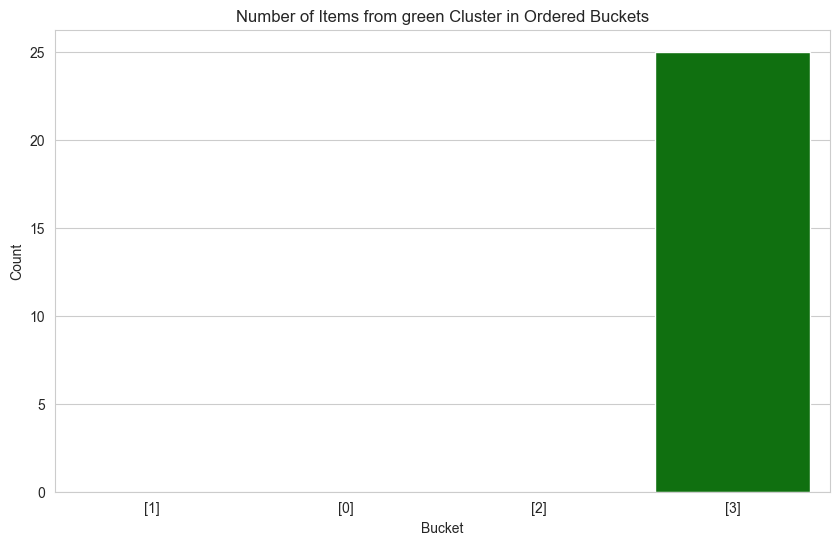

In [12]:
bucket_order = results['bucket_order'][0]  # Adjust according to where bucket_order comes from
order_labels = [str(list(bucket)) for bucket in bucket_order]  # Convert to string with brackets

# Extract the counts for the specified color
cluster_specific_counts = bucket_cluster_counts[filter_color]

# Reindex the bucket counts according to the specified order
ordered_counts = cluster_specific_counts.reindex(order_labels, fill_value=0).reset_index()
ordered_counts.columns = ['bucket', 'count']

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=ordered_counts, x='bucket', y='count', color=filter_color)
plt.title(f'Number of Items from {filter_color} Cluster in Ordered Buckets')
plt.xlabel('Bucket')
plt.ylabel('Count')
plt.show()

In [13]:
filter_color = "green"
results = collection.query(
    query_embeddings=list(query_point),
    include=["metadatas", 'embeddings', 'distances'],
    where={"cluster": filter_color},
    n_results=10,
    n_buckets=4,
    use_threshold=False, # TODO: this causes problems, hotfix applied for now
    constraint_weight=0.5,
)

[2023-12-18 21:57:47,958][INFO ][chromadb.lmi.lmi.LMI] Precompute bucket order time: 0.0
100%|██████████| 4/4 [00:00<00:00, 1856.50it/s]


In [14]:
print(results['ids'])
print(results['distances'])
print(results['metadatas'])
print(results['bucket_order'])

[['id17', 'id34', 'id65', 'id62', 'id72', 'id38', 'id80', 'id29', 'id69', 'id59']]
[[0.6262323930864448, 0.6717660904129665, 0.6769973154206039, 0.6785212108825407, 0.6843694476948987, 0.6897005824034199, 0.6954903155504598, 0.7069224906462632, 0.7208787932161458, 0.7399165530878204]]
[[{'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}, {'cluster': 'green'}]]
[[[3]
  [1]
  [0]
  [2]]]


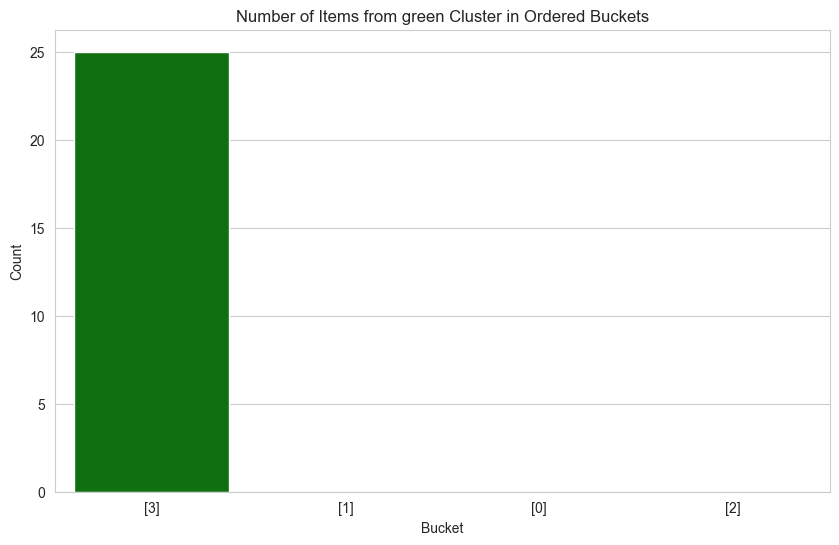

In [15]:
bucket_order = results['bucket_order'][0]  # Adjust according to where bucket_order comes from
order_labels = [str(list(bucket)) for bucket in bucket_order]  # Convert to string with brackets

# Extract the counts for the specified color
cluster_specific_counts = bucket_cluster_counts[filter_color]

# Reindex the bucket counts according to the specified order
ordered_counts = cluster_specific_counts.reindex(order_labels, fill_value=0).reset_index()
ordered_counts.columns = ['bucket', 'count']

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=ordered_counts, x='bucket', y='count', color=filter_color)
plt.title(f'Number of Items from {filter_color} Cluster in Ordered Buckets')
plt.xlabel('Bucket')
plt.ylabel('Count')
plt.show()